In [3]:
!pip install nlp

In [4]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [5]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [6]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [7]:
def get_tweets(data):
    tweets = [d['text'] for d in data]
    labels = [d['label'] for d in data]
    return tweets, labels

In [8]:
tweets, labels = get_tweets(train)

In [9]:
tweets[2], labels[2]

('im grabbing a minute to post i feel greedy wrong', 'anger')

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [13]:
tokenizer.texts_to_sequences([tweets[2]])

[[17, 3060, 7, 1149, 5, 286, 2, 3, 495, 438]]

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
def get_sequences(tokenizer, tweets, max_len):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len)
  return padded

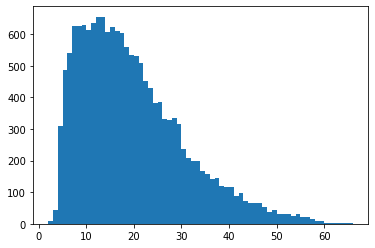

In [17]:
lengths = [len(tweet.split(' ')) for tweet in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [19]:
max_len = 50

In [20]:
padded_train_seq = get_sequences(tokenizer, tweets, max_len)

In [21]:
padded_train_seq[2]

array([  17, 3060,    7, 1149,    5,  286,    2,    3,  495,  438,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [22]:
classes = set(labels)
print(classes)

{'anger', 'joy', 'fear', 'love', 'surprise', 'sadness'}


In [23]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [24]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [25]:
train_labels = names_to_ids(labels)
print(train_labels[2])

0


In [26]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16, input_length=50),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [28]:
val_tweets, val_labels = get_tweets(val)
val_seq = get_sequences(tokenizer, val_tweets, max_len)
val_labels = names_to_ids(val_labels)

In [29]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [30]:
f = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 16s 15ms/step - loss: 1.2990 - accuracy: 0.4832 - val_loss: 0.8422 - val_accuracy: 0.6715
Epoch 2/20
500/500 [==============================] - 6s 13ms/step - loss: 0.5908 - accuracy: 0.7812 - val_loss: 0.6041 - val_accuracy: 0.7910
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3275 - accuracy: 0.8871 - val_loss: 0.4366 - val_accuracy: 0.8465
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2192 - accuracy: 0.9271 - val_loss: 0.3768 - val_accuracy: 0.8760
Epoch 5/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1583 - accuracy: 0.9486 - val_loss: 0.3597 - val_accuracy: 0.8925
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1185 - accuracy: 0.9613 - val_loss: 0.3627 - val_accuracy: 0.8945
Epoch 7/20
500/500 [==============================] - 6s 13ms/step - loss: 0.0867 - accuracy: 0.9720 - val_loss: 0.3917 - val_accuracy: 0.896

In [31]:
def show_history(f):
    epochs_trained = len(f.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), f.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), f.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), f.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), f.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


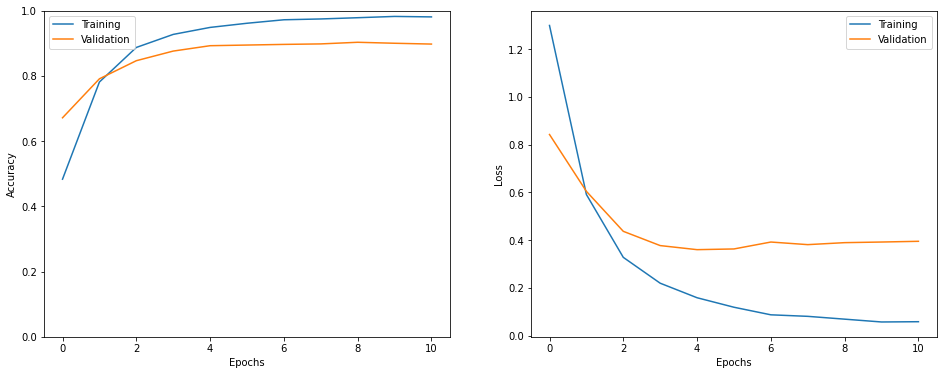

In [32]:
show_history(f)

In [33]:
test_tweets, test_labels = get_tweets(test)
test_seq = get_sequences(tokenizer,test_tweets,max_len)
test_labels = names_to_ids(test_labels)

In [34]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 12ms/step - loss: 0.4010 - accuracy: 0.8930


In [35]:
i = random.randint(0,len(test_labels)-1)

print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted emotion: ', pred_class)

Sentence:  i have a feeling that its too sociable
Emotion:  joy
Predicted emotion:  joy
